In [1]:
import sqlite3
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as seb

In [2]:
### LOAD DATA FROM CSV INTO SQL DATABASE
DB_FILE = 'netflix.db'
# if DB file does not exist use the csv data to populate it
if not os.path.exists(DB_FILE):    
    titles = pd.read_csv('titles.csv')
    # make the database connection
    dbcon = sqlite3.connect(DB_FILE)
    # create empty tables with the correct relationships for population with the csv data
    create_titles = '''CREATE TABLE IF NOT EXISTS Titles (
                                            id TEXT PRIMARY KEY,
                                            title TEXT,
                                            type TEXT,
                                            description TEXT,
                                            release_year INTEGER,
                                            age_certification TEXT,
                                            runtime INTEGER,
                                            genres TEXT,
                                            production_countries TEXT,
                                            seasons INTEGER,
                                            imdb_id TEXT,
                                            imdb_score INTEGER,
                                            imdb_votes INTEGER,
                                            tmdb_popularity INTEGER,
                                            tmdb_score INTEGER
                                        );'''
    create_credits = '''CREATE TABLE IF NOT EXISTS Credits (
                                            person_id INTEGER NOT NULL,
                                            id TEXT NOT NULL,
                                            name TEXT NOT NULL,
                                            character TEXT,
                                            role TEXT,
                                            FOREIGN KEY (id) REFERENCES title(id)
                                        );'''
    cur = dbcon.cursor() # create the above empty tables
    cur.execute(create_titles)
    cur.execute(create_credits)
    # use pandas to read the data for easy storage into the SQLite db
    titles = pd.read_csv('titles.csv')
    titles.to_sql('Titles', con=dbcon, if_exists='append', index=False)
    credits = pd.read_csv('credits.csv')
    credits.to_sql('Credits', con=dbcon, if_exists='append', index=False)

    dbcon.close()


[[1.32556035 0.7733128 ]
 [0.7733128  1.3062808 ]]


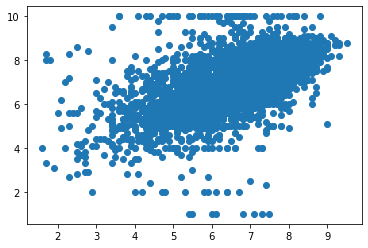

In [16]:
# EDA
dbcon = sqlite3.connect(DB_FILE)
cur = dbcon.cursor()

cur.execute('''
SELECT imdb_score, tmdb_score FROM Titles WHERE imdb_score NOT NULL AND tmdb_score NOT NULL
''')
cur.row_factory = lambda cursor, row: list(row)
scores = np.array(cur.fetchall()).T
#print(scores[0])
plt.scatter(scores[0], scores[1])
print(np.cov(scores))

In [41]:
cur.row_factory = lambda cursor, row: list(row)
role_rating = '''
SELECT DISTINCT name FROM Credits
'''
score_by_year = '''
SELECT * FROM
(
SELECT  Credits.name, Titles.release_year, Titles.imdb_score
FROM Credits
INNER JOIN Titles ON Titles.id = Credits.id
WHERE Titles.release_year > 1990
) temp_table
PIVOT (
AVG(imdb_score)
FOR category_name IN (
Mobile,
Headphone,
Tablet)
) pivot_table;
'''
cur.execute(role_rating)
roles = cur.fetchall()
print(roles)

[['Robert De Niro'], ['Jodie Foster'], ['Albert Brooks'], ['Harvey Keitel'], ['Cybill Shepherd'], ['Peter Boyle'], ['Leonard Harris'], ['Diahnne Abbott'], ['Gino Ardito'], ['Martin Scorsese'], ['Murray Moston'], ['Richard Higgs'], ['Bill Minkin'], ['Bob Maroff'], ['Victor Argo'], ['Joe Spinell'], ['Robinson Frank Adu'], ['Brenda Dickson'], ['Norman Matlock'], ['Harry Northup'], ['Harlan Cary Poe'], ['Steven Prince'], ['Peter Savage'], ['Nicholas Shields'], ['Ralph S. Singleton'], ['Annie Gagen'], ['Carson Grant'], ['Mary-Pat Green'], ['Debbi Morgan'], ['Don Stroud'], ['Copper Cunningham'], ['Garth Avery'], ['Nat Grant'], ['Billie Perkins'], ['Catherine Scorsese'], ['Charles Scorsese'], ['Graham Chapman'], ['John Cleese'], ['Eric Idle'], ['Terry Gilliam'], ['Terry Jones'], ['Michael Palin'], ['Connie Booth'], ['Carol Cleveland'], ['Neil Innes'], ['Bee Duffell'], ['John Young'], ['Rita Davies'], ['Avril Stewart'], ['Sally Kinghorn'], ['Mark Zycon'], ['Elspeth Cameron'], ['Mitsuko Forstat